# CUSTOMER SEGMENTATION AND RFM MODELS (R = Recency, F = Frequency, M = Monetary)

- Customer segmentation is a method of dividing customers into groups or clusters on the basis of common characteristics.
- The market researcher can segment customers into the B2C model using various customer's demographic characteristics such as occupation, gender, age, location, and marital status.
- Psychographic characteristics such as social class, lifestyle and personality characteristics and behavioral characteristics such as spending, consumption habits, product/service usage, and previously purchased products.
- In the B2B model using various company's characteristics such as the size of the company, type of industry, and location.



**Why is it useful?**
- We can use it to group customers by the month of the first purchase, segment by their recency, frequency, and monetary values or run k-means clustering to identify similar groups of customers based on their purchasing behaviour
- By using this technique, marketers can identify which customers are the most valuable and tailor their marketing strategy accordingly

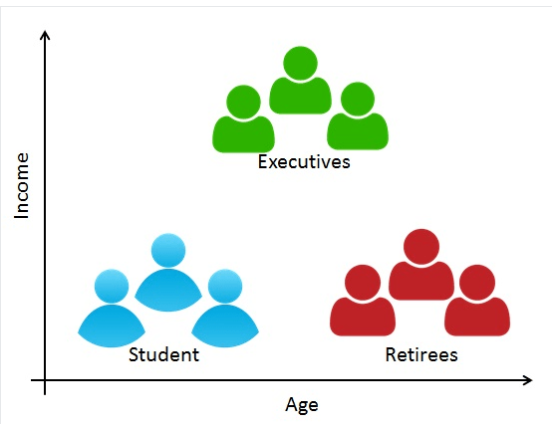

##**Cohort analysis**
- Groups customers into mutually exclusive cohorts which are then measured over time
- Helps with understanding the high lvl. trends by providing insights on metrics across both the product and customer lifecycle

There are 3 cohort types:
- 1) **Time cohort** - Customers who signed up for a product or service during a particular time frame, the time can be monthly/quarterly/daily..., Analyzing these cohorts shows the behaviour of customers depending on when they started using the product / service

- 2) **Behaviour cohorts** - customers who bought a product/service in the past. It groups customers by the type of product or service they signed up for (those who signed up for basic lvl. service might have different needs than those who signed up for advanced services)

- 3) **Size cohorts** - Refer to various sizes of customers who purchases company´s product/service. It can be based on the amount of spending in some period of time after acquisition

- The data is typically formatted as a pivot table where the row values represent the cohort

In [ ]:
# IMPORTS
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# EXERCISE - Online retail data
df = pd.read_excel("Online Retail.xlsx")
df = df.sample(frac = 0.2) # Getting random 20% of the rows only
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
464456,576096,22423,REGENCY CAKESTAND 3 TIER,2,2011-11-14 09:20:00,12.75,13549.0,United Kingdom
440992,574559,23275,SET OF 3 HANGING OWLS OLLIE BEAK,12,2011-11-04 15:50:00,1.25,14056.0,United Kingdom
179940,552293,23154,SET OF 4 JAM JAR MAGNETS,12,2011-05-08 14:05:00,2.08,16232.0,United Kingdom


## Observing the dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108382 entries, 464456 to 378982
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    108382 non-null  object        
 1   StockCode    108382 non-null  object        
 2   Description  108111 non-null  object        
 3   Quantity     108382 non-null  int64         
 4   InvoiceDate  108382 non-null  datetime64[ns]
 5   UnitPrice    108382 non-null  float64       
 6   CustomerID   81628 non-null   float64       
 7   Country      108382 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 7.4+ MB


In [ ]:
df.shape

(108382, 8)

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,108382.000000,108382.000000,81628.000000
mean,10.380820,4.190136,15288.679853
std,230.495017,41.079310,1711.398334
min,-3100.000000,0.000000,12346.000000
25%,1.000000,1.250000,13969.000000
50%,3.000000,2.080000,15154.000000
75%,10.000000,4.130000,16788.000000
max,74215.000000,7006.830000,18287.000000


In [ ]:
df.Country.value_counts()

United Kingdom          99096
Germany                  1923
France                   1724
EIRE                     1602
Spain                     527
Netherlands               458
Switzerland               425
Belgium                   393
Portugal                  301
Australia                 256
Norway                    235
Italy                     154
Channel Islands           132
Finland                   118
Cyprus                    115
Unspecified               102
Sweden                     94
Austria                    87
Denmark                    74
Poland                     68
Japan                      67
USA                        65
Israel                     62
Hong Kong                  50
Singapore                  46
Iceland                    36
Canada                     32
Malta                      30
Greece                     30
European Community         16
RSA                        13
Lebanon                    13
United Arab Emirates       10
Lithuania 

- We can see that most of the customers are from the UK

**Duplicate values**

In [ ]:
duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f"There are {duplicate_count} duplicate rows in the DataFrame.")
else:
    print("No duplicates found in the DataFrame.")

There are 224 duplicate rows in the DataFrame.


In [ ]:
df = df.drop_duplicates()

### Creating cohorts

In [ ]:
# Defining useful functions
def get_month(x):
  """Truncates a given date object to a 1st day of the month and year"""
  first_day = dt.datetime(x.year, x.month, 1) # accesses the year, month, and the first day of the month
  return first_day


def get_date_int(df, column):
  """Extracts year, month, and day integer values from a given column"""
  year = df[column].dt.year
  month = df[column].dt.month
  day = df[column].dt.day
  return year, month, day

In [ ]:
# Creating 2 new columns - InvoiceMonth, and CohortMonth
df["InvoiceMonth"] = df["InvoiceDate"].apply(get_month)
grouping = df.groupby("CustomerID")["InvoiceMonth"] # creates a series of the "InvoiceMonth" for each customer (each customer can have many invoices)
df["CohortMonth"] = grouping.transform("min") # assigns the smallest "InvoiceMonth" value to each customer (to get the first invoice of the customer)

In [ ]:
# Calculating the nr. of months between each customer transaction and their first transaction
invoice_year, invoice_month, _ = get_date_int(df, "InvoiceMonth") # Gets the year and month integer values of each invoice (ignores the day)
cohort_year, cohort_month, _ = get_date_int(df, "CohortMonth")

years_dif = invoice_year - cohort_year     # The nr. of years difference
months_dif = invoice_month - cohort_month  # The nr. of months difference

df["CohortIndex"] = years_dif * 12 + months_dif + 1  # Getting the total difference in months (the +1 is there so that the 1st month is marked as 1 not 0)
# For days it would be: df["CohortIndex"] = years_dif * 365 + months_dif * 30 + days_dif + 1

In [ ]:
# Calculating the nr. of monthly active customers from each cohort
grouping = df.groupby(["CohortMonth", "CohortIndex"])
cohort_data = grouping["CustomerID"].apply(pd.Series.nunique) # Counts the nr. of customers in each group
cohort_data = cohort_data.reset_index()

# Creating a pivot table
cohort_counts = cohort_data.pivot(index = "CohortMonth",   # Index = Rows
                                  columns = "CohortIndex",
                                  values = "CustomerID")

In [ ]:
cohort_counts

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,799.0,289.0,248.0,294.0,276.0,320.0,295.0,272.0,285.0,301.0,293.0,397.0,205.0
2011-01-01,401.0,89.0,109.0,93.0,127.0,114.0,101.0,100.0,120.0,124.0,147.0,54.0,NaN
2011-02-01,342.0,65.0,60.0,93.0,84.0,81.0,82.0,97.0,85.0,108.0,25.0,NaN,NaN
2011-03-01,425.0,68.0,100.0,89.0,97.0,77.0,98.0,94.0,114.0,33.0,NaN,NaN,NaN
2011-04-01,281.0,60.0,52.0,53.0,52.0,65.0,59.0,71.0,18.0,NaN,NaN,NaN,NaN
2011-05-01,270.0,54.0,43.0,42.0,57.0,66.0,68.0,24.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,237.0,35.0,32.0,59.0,50.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,186.0,32.0,36.0,42.0,45.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,163.0,30.0,40.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Calculating Metrics

**Retention rate** - Customer retention is a very useful metric to understand how many of all the customers are still active. It gives the % of active customers compared to the total nr. of customers

In [ ]:
# Calculating the retention rates:
cohort_sizes = cohort_counts.iloc[:, 0] # Selecting the 1st column from the table
retention = cohort_counts.divide(cohort_sizes, axis = 0)
retention = retention.round(3) * 100
retention

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,100.0,36.2,31.0,36.8,34.5,40.1,36.9,34.0,35.7,37.7,36.7,49.7,25.7
2011-01-01,100.0,22.2,27.2,23.2,31.7,28.4,25.2,24.9,29.9,30.9,36.7,13.5,NaN
2011-02-01,100.0,19.0,17.5,27.2,24.6,23.7,24.0,28.4,24.9,31.6,7.3,NaN,NaN
2011-03-01,100.0,16.0,23.5,20.9,22.8,18.1,23.1,22.1,26.8,7.8,NaN,NaN,NaN
2011-04-01,100.0,21.4,18.5,18.9,18.5,23.1,21.0,25.3,6.4,NaN,NaN,NaN,NaN
2011-05-01,100.0,20.0,15.9,15.6,21.1,24.4,25.2,8.9,NaN,NaN,NaN,NaN,NaN
2011-06-01,100.0,14.8,13.5,24.9,21.1,28.7,9.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,100.0,17.2,19.4,22.6,24.2,11.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,100.0,18.4,24.5,25.2,12.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- The first column has 100% retention rate for all cohorts as expected

In [ ]:
# Calculating the average quantities purchased:
grouping = df.groupby(["CohortMonth", "CohortIndex"])
cohort_data = grouping["Quantity"].mean()
cohort_data = cohort_data.reset_index()
avg_quantity = cohort_data.pivot(index = "CohortMonth",
                                     columns = "CohortIndex",
                                     values = "Quantity")
avg_quantity = avg_quantity.round(1)
avg_quantity

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,11.8,14.0,17.4,13.9,11.3,15.4,14.0,13.0,16.7,16.6,16.7,12.4,12.9
2011-01-01,43.5,11.2,13.2,6.6,11.2,16.3,14.2,15.8,12.2,11.1,9.8,13.9,NaN
2011-02-01,10.5,14.7,25.6,11.2,8.9,11.5,12.9,14.0,12.8,14.3,28.2,NaN,NaN
2011-03-01,10.6,13.0,13.8,10.8,16.0,14.0,12.5,19.8,9.0,12.5,NaN,NaN,NaN
2011-04-01,9.4,11.4,8.8,11.5,11.2,8.0,8.4,10.1,7.2,NaN,NaN,NaN,NaN
2011-05-01,10.3,8.4,16.3,12.3,10.7,8.8,10.7,8.6,NaN,NaN,NaN,NaN,NaN
2011-06-01,11.5,10.7,15.7,13.4,10.6,11.9,10.7,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,11.1,17.9,9.7,10.1,5.8,7.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,10.6,5.4,5.6,6.4,6.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating cohort visualisation

**Heatmap** - We use heatmaps as they enable to easily visualise our cohort analysis and are easy to implement

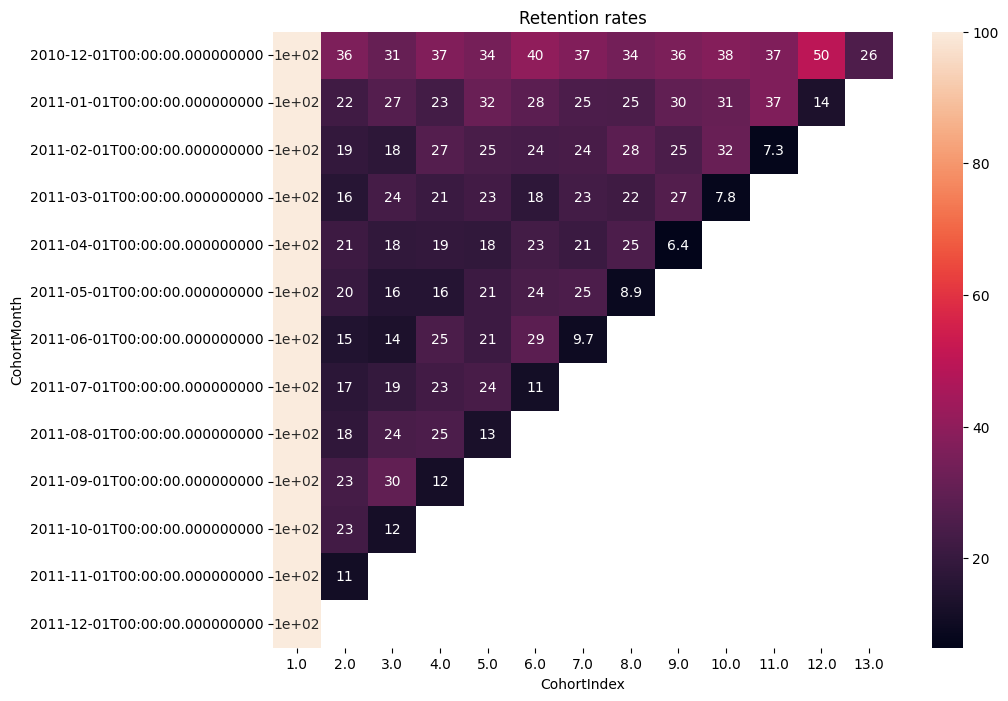

In [ ]:
plt.figure(figsize = (10, 8))
plt.title("Retention rates")
sns.heatmap(data = retention, annot = True)
plt.show()

## RFM Segmentation analysis

We need 3 customer behaviour metrics:
- 1) **Recency (R)** - Measures how recent was each customer´s last purchase - The lower it is, the better (= nr. of days since last customer transactions)
- 2) **Frequency (F)** - Measures how many purchases the customer has done in the last 12 months - The higher it is, the better (= nr. of transactions in the last 12 mths)
- 3) **Monetery value (M)** - Measures how much has the customer spent in the last 12 months - The higher it is, the better

We will use these 3 metrics to assign customers to RFM segments and we will then group them in certain groups

**This grouping can be done in several ways:**
- Break the customers into groups of equal size based on percentile values of each metric
- Assigning high/low value to each metric based on the 80/20 % Pareto split
- Using existing knowledge from previous business insights about certain threshold values for each metric

We need to preprocess the dataframe so that is only includes the most recent 12 mths of data (the most recent snapshot of data from today)

In [ ]:
print("Min:{}; Max:{}".format(min(df.InvoiceDate),
                              max(df.InvoiceDate)))

Min:2010-12-01 08:26:00; Max:2011-12-09 12:50:00


Here we can see we have this done as the df only includes 12 months of most recent data

The data starts from 2010 so we have to create a hypothetical snapshot data that we will use as a starting point to calculate metrics as if we are doing analysis on the most recent data

In [ ]:
snapshot_date = max(df.InvoiceDate) + dt.timedelta(days = 1)
snapshot_date

Timestamp('2011-12-10 12:50:00')

- So we have the snapshot date and the last 12 months most recently available
- The snapshot date would be today in the real world

In [ ]:
df["TotalSum"] = df["UnitPrice"] * df["Quantity"]

#### Calculating the RFM values

In [ ]:
# Calculating the RFM Metrics:
datamart = df.groupby(["CustomerID"]).agg({
    "InvoiceDate": lambda date: (snapshot_date - date.max()).days,  # The nr. of days between the hypothetical today and the last transaction
    "InvoiceNo": "count",
    "TotalSum": "sum"})

# Renaming the columns:
datamart.rename(columns = {"InvoiceDate": "Recency", # Nr. of days since last customer transaction
                           "InvoiceNo": "Frequency", # Nr. of products purchased in last 12 mths
                           "TotalSum": "MonetaryValue"}, inplace = True) # Total spending in last 12 mths

datamart.head(5)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,36,1035.83
12348.0,75,7,468.96
12349.0,19,14,257.48
12350.0,310,5,119.30


We will now group customers into 4 segments of the same size for each RFM value

#### Calculating the RFM quartiles

In [ ]:
# Creating Recency quartiles (recency is better low)
r_labels = range(4, 0, -1) # We will rate customers who have been active more recently better than the less recent customers
r_quartiles = pd.qcut(datamart["Recency"], 4, labels = r_labels) # Sorting the customers by their recency value in increasing order and then assigns values from 4 to 1 based on the quartile they fall into
datamart = datamart.assign(R = r_quartiles.values) # Assigns these values to a new column R

# Creating Frequency quartiles (frequency is better high - so we assign higher labels to higher values)
f_labels = range(1, 5)
f_quartiles = pd.qcut(datamart["Frequency"], 4, labels = f_labels)  # The 4 there means we want to group the customers into 4 separate groups
datamart = datamart.assign(F = f_quartiles.values)

# Creating Monetary value quartiles (Monetary value is better high - so we assign higher labels to higher values)
m_labels = range(1, 5)
m_quartiles = pd.qcut(datamart["MonetaryValue"], 4, labels = m_labels)
datamart = datamart.assign(M = m_quartiles.values)

In [ ]:
datamart

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,4
12347.0,2,36,1035.83,4,4,4
12348.0,75,7,468.96,2,2,4
12349.0,19,14,257.48,3,3,3
12350.0,310,5,119.30,1,2,2
...,...,...,...,...,...,...
18277.0,58,3,51.17,2,1,1
18280.0,278,3,56.55,1,1,1
18282.0,8,4,46.31,4,1,1


- So now all customers have a quartile value assigned that we will use to build the segmentation

**RFM Segment** = Concatenated string of RFM values

**RFM Score** = Sum of RFM values



In [ ]:
# Creating the RFM Segment
to_convert = ["R", "F", "M"]
datamart[to_convert] = datamart[to_convert].apply(pd.to_numeric, errors = "coerce").fillna(0).astype(int) # Converts to numeric type, handling errors by coercing invalid values to NaN. Then, it fills NaN values with 0 and converts the columns to integers

def join_rfm(x):
  """Creates a concatenated list of RFM values converted to strings"""
  joined_rfm = str(x["R"]) + str(x["F"]) + str(x["M"])
  return joined_rfm

datamart["RFM_Segment"] = datamart.apply(join_rfm, axis = 1)  # Appling this function across the columns

# Creating the RFM Score
datamart["RFM_Score"] = datamart[["R", "F", "M"]].sum(axis = 1)  # Summing across the columns

In [ ]:
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,36,1035.83,4,4,4,444,12
12348.0,75,7,468.96,2,2,4,224,8
12349.0,19,14,257.48,3,3,3,333,9
12350.0,310,5,119.30,1,2,2,122,5
...,...,...,...,...,...,...,...,...
18277.0,58,3,51.17,2,1,1,211,4
18280.0,278,3,56.55,1,1,1,111,3
18282.0,8,4,46.31,4,1,1,411,6


#### Analyzing the RFM Segments

In [ ]:
# Observing the largest 10 RFM Segments
datamart.groupby("RFM_Segment").size().sort_values(ascending = False)[:10]

RFM_Segment
444    414
111    374
344    202
211    192
333    156
222    155
122    146
233    144
112    135
433    131
dtype: int64

- The highest rated RFM Segment (444) has the most amount of customers = 414
- The lowest rated RFM segment (111) has the 2nd most amount of customers = 374

In [ ]:
datamart.groupby("RFM_Score").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           256.0       2.1          17.0   374
4           177.1       3.2          46.4   402
5           146.9       4.6          74.7   450
6           104.1       6.4         298.9   464
7            85.2       8.9         168.9   427
8            64.0      12.8         210.8   416
9            48.1      17.2         330.6   395
10           33.5      24.5         470.6   414
11           21.2      41.5         769.1   360
12            7.4      80.5        1932.1   414

We often group the customers based on their RFM score into an even smaller nr. of segments

In [ ]:
def segment_me(df):
  if df["RFM_Score"] >= 9:
    return "Gold"
  elif (df["RFM_Score"] >= 5) and (df["RFM_Score"] < 9):
    return "Silver"
  else:
    return "Bronze"

datamart["General_Segment"] = datamart.apply(segment_me, axis = 1)
datamart

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6,Silver
12347.0,2,36,1035.83,4,4,4,444,12,Gold
12348.0,75,7,468.96,2,2,4,224,8,Silver
12349.0,19,14,257.48,3,3,3,333,9,Gold
12350.0,310,5,119.30,1,2,2,122,5,Silver
...,...,...,...,...,...,...,...,...,...
18277.0,58,3,51.17,2,1,1,211,4,Bronze
18280.0,278,3,56.55,1,1,1,111,3,Bronze
18282.0,8,4,46.31,4,1,1,411,6,Silver


In [ ]:
datamart.groupby("General_Segment").agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Bronze            215.1       2.7          32.3   776
Gold               27.5      41.2         885.8  1583
Silver            101.0       8.1         189.0  1757

# Data Preprocessing for K-Means clustering

### K-Means Critical Assumptions

- 1) All variables must have symmetrical distributions (not skewed)
- 2) All variables have the same average/mean values
- 3) All variables must have the same variance

**Dealing with negative values** - The simplest way is to add a constant value to each variable (např. the absolute value of the lowest negative value to each observation and then a small constant like 1 to force the variables to be strictly positive)

**Note** - Luckily, customer behaviour data is almost always positive so we do not have to worry about this

However, here some of the monetary values are negative so we can just remove these

In [ ]:
datamart["MonetaryValue"].sort_values().head(50)

CustomerID
12744.0   -1972.40
17940.0   -1565.46
12503.0   -1126.00
13984.0    -386.13
12454.0    -312.80
13564.0    -301.73
17603.0    -293.42
14557.0    -276.40
13587.0    -274.20
13762.0    -156.72
18024.0    -120.29
13672.0     -89.13
15365.0     -84.57
12607.0     -76.26
16252.0     -73.40
18072.0     -54.96
15823.0     -54.90
16321.0     -42.45
17406.0     -36.70
17548.0     -36.30
13008.0     -35.70
16714.0     -32.83
12558.0     -20.80
16689.0     -20.00
16262.0     -19.90
16239.0     -19.20
14304.0     -16.75
14147.0     -15.00
13958.0     -12.75
14586.0     -12.48
16424.0     -10.44
15212.0      -9.95
14295.0      -8.50
18274.0      -5.88
12888.0      -4.65
13693.0      -4.25
12565.0      -3.77
13217.0      -3.40
12852.0      -2.95
16428.0      -2.95
16878.0      -2.55
17658.0      -2.52
16998.0      -0.48
16233.0      -0.15
15802.0       0.00
16272.0       0.55
12977.0       0.65
16427.0       0.84
16913.0       1.25
15049.0       1.70
Name: MonetaryValue, dtype: float64

In [ ]:
# Getting rid of the negative monetary values
datamart = datamart[datamart["MonetaryValue"] > 0]

**How to identify skewed variables?** - by looking at each variable´s distribution

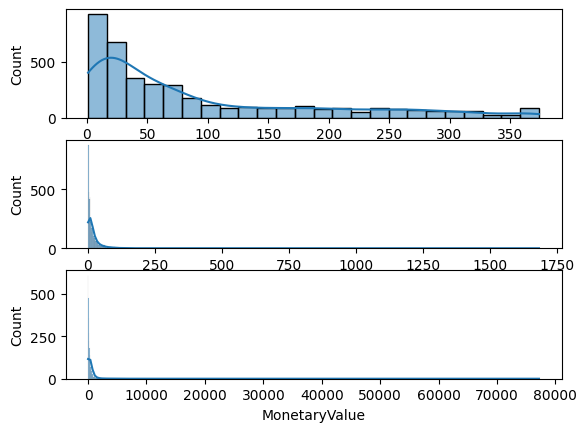

In [ ]:
# Recency distribution
plt.subplot(3, 1, 1)
sns.histplot(datamart["Recency"], kde = True)

# Frequency distribution
plt.subplot(3, 1, 2)
sns.histplot(datamart["Frequency"], kde = True)

# Monetary value distribution
plt.subplot(3, 1, 3)
sns.histplot(datamart["MonetaryValue"], kde = True)

plt.show()

- We can see there is a heavy right skew for Frequency and Monetary value and a small right skew for Recency as well

**1) How to unskew the data?** - By appling Logarithmic Transformation = but this only works on positive values!!!!!!

In [ ]:
# Only getting the 3 columns we need:
datamart_rfm = datamart[["Recency", "Frequency", "MonetaryValue"]]
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,4071.000000,4071.000000,4071.000000
mean,93.345124,19.925817,434.018973
std,99.808908,48.363828,2052.454195
min,1.000000,1.000000,0.550000
25%,18.000000,4.000000,60.300000
50%,52.000000,9.000000,143.400000
75%,145.000000,22.000000,348.325000
max,374.000000,1683.000000,77183.600000


In [ ]:
# Appling log transformation:
datamart_rfm_log = np.log(datamart_rfm)

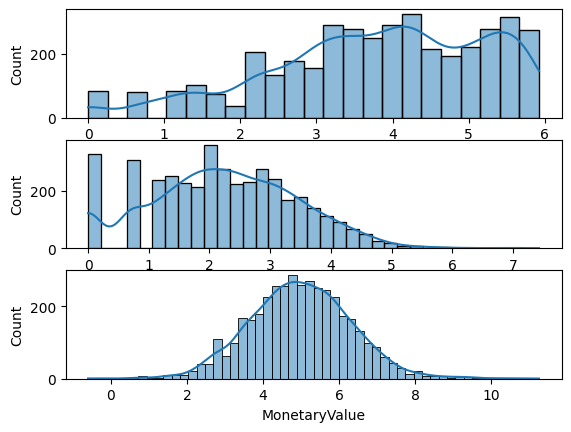

In [ ]:
plt.subplot(3, 1, 1)
sns.histplot(datamart_rfm_log["Recency"], kde = True)

plt.subplot(3, 1, 2)
sns.histplot(datamart_rfm_log["Frequency"], kde = True)

plt.subplot(3, 1, 3)
sns.histplot(datamart_rfm_log["MonetaryValue"], kde = True)

plt.show()

**2) + 3) Centering variables with different means and different variances**

In [ ]:
ss = StandardScaler()
ss.fit(datamart_rfm_log)
datamart_normalised = ss.transform(datamart_rfm_log)

print("mean: ", datamart_normalised.mean(axis = 0).round(2))
print("std: ", datamart_normalised.std(axis = 0).round(2))

mean:  [-0.  0. -0.]
std:  [1. 1. 1.]


- We can see that now the means and variances are the same which is what we wanted

**Note:**

datamart_rfm = raw data

datamart_normalised = preprocessed data

### Applying K-Means Clustering

- we need to decide on the nr. of clusters (Elbow method)

In [ ]:
random_state = 42
n_clusters = 2
kmeans = KMeans(n_clusters = n_clusters, random_state = random_state)
kmeans.fit(datamart_normalised)
cluster_labels = kmeans.labels_

Analysing how these clusters differ from each other by using the raw data:

In [ ]:
datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels) # Adding a Cluster column which has cluster labels as the values to the datamart_rfm dataframe
datamart_rfm_k2

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346.0,326,1,77183.60,1
12347.0,2,36,1035.83,1
12348.0,75,7,468.96,1
12349.0,19,14,257.48,1
12350.0,310,5,119.30,0
...,...,...,...,...
18277.0,58,3,51.17,0
18280.0,278,3,56.55,0
18282.0,8,4,46.31,0


In [ ]:
datamart_rfm_k2.groupby(["Cluster"]).agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         143.4       5.7          95.9  2258
1          31.0      37.6         855.1  1813

- Cluster 1 has customers who have not been very recent, are less frequent with their puchases and the monetary values are also way lower than those of Cluster 0

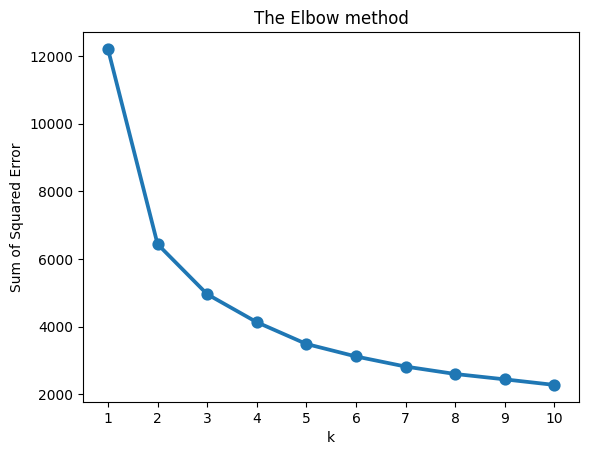

In [ ]:
# Elbow criterion method
sse = {}
for k in range(1, 11): # Trying different nr. of clusters from 1 to 10
  kmeans = KMeans(n_clusters = k, random_state = random_state)
  kmeans.fit(datamart_normalised)
  sse[k] = kmeans.inertia_ # Sum of squared error

# Plotting it
plt.title("The Elbow method")
plt.xlabel("k")
plt.ylabel("Sum of Squared Error")
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show()

- We are looking for the largest angle (here např. number 4 looks like it)
- We can experiment and be advised with the business to see which solution makes the most sense (how many clusters they are looking for)

**How to profile and interpret the segments**
- Using snake plots = chart that visualises RFM values between the segments
- Calculating relative importance of cluster attrributes compared to the population average

Firstly when we use 2 clusters:

In [ ]:
datamart_rfm_k2 = datamart_rfm.assign(Cluster = cluster_labels) # Adding a column "Cluster" to the datamart_rfm dataframe

datamart_rfm_k2.groupby(["Cluster"]).agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         143.0       6.0          96.0  2258
1          31.0      38.0         855.0  1813

Now combining it to when we use 3 clusters:

In [ ]:
random_state = 42
kmeans3 = KMeans(n_clusters = 3, random_state = random_state)
kmeans3.fit(datamart_normalised)
cluster_labels = kmeans3.labels_

datamart_rfm_k3 = datamart_rfm.assign(Cluster = cluster_labels) # Adding a column "Cluster" to the datamart_rfm dataframe

datamart_rfm_k3.groupby(["Cluster"]).agg({
    "Recency": "mean",
    "Frequency": "mean",
    "MonetaryValue": ["mean", "count"]}).round(0)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          78.0      14.0         280.0  1755
1         170.0       3.0          58.0  1354
2          14.0      54.0        1244.0   962

**Using Snake plots**

In [ ]:
# Transforming datamart_normalised as a Pandas DataFrame
datamart_normalised = pd.DataFrame(datamart_normalised,
                                   index = datamart_rfm.index,
                                   columns = datamart_rfm.columns)
datamart_normalised["Cluster"] = datamart_rfm_k3["Cluster"]

# Melting the dataset into a long format for easier plotting
datamart_melt = pd.melt(datamart_normalised.reset_index(),
                        id_vars = ["CustomerID", "Cluster"],
                        value_vars = ["Recency", "Frequency", "MonetaryValue"],
                        var_name = "Attribute",
                        value_name = "Value")

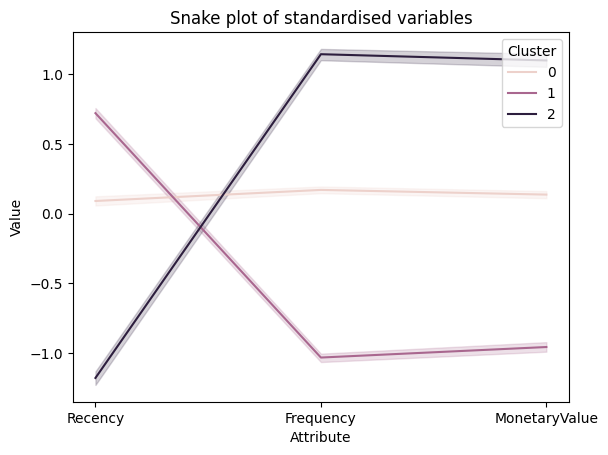

In [ ]:
# Visualising the snake plot:
plt.title("Snake plot of standardised variables")
sns.lineplot(x = "Attribute", y = "Value", hue = "Cluster", data = datamart_melt)
plt.show()

**Identifying relative importance of segment attributes**

In [ ]:
# Calculating the relative importance score for each RFM value of the segments
cluster_avg = datamart_rfm_k3.groupby(["Cluster"]).mean()
population_avg = datamart_rfm.mean()
relative_imp = (cluster_avg / population_avg) - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.17,-0.30,-0.35
1,0.82,-0.83,-0.87
2,-0.85,1.73,1.87


- The further the ratio is from zero, the more important that attribute is for defining a specific cluster compared to the population average

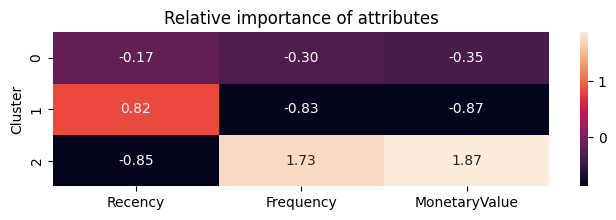

In [ ]:
 # Visualising it through a heatmap
 plt.figure(figsize = (8, 2))
 plt.title("Relative importance of attributes")
 sns.heatmap(data = relative_imp, annot = True, fmt = ".2f")
 plt.show()